In [300]:
import numpy as np
import matplotlib.pyplot as plt
from trainSpringerSegmentationAlgorithm import trainSpringerSegmentationAlgorithm
from runSpringerSegmentationAlgorithm import runSpringerSegmentationAlgorithm
from scipy.signal import envelope, butter, filtfilt, find_peaks, hilbert

In [2]:
include_wavelet = 0
featuresFs = 50
fs = 1000  # original sampling frequency

In [3]:
audio_train = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_2-JORGE-20051201021025/pcg_cut_matlab.txt')
envol = envelope(audio_train, residual=None)
# low pass filter for the envelope
lowcut = 40.0
fs = 1000.0
b, a = butter(1, lowcut, btype='lowpass', fs=fs)
envol = filtfilt(b, a, envol)
r_peaks_train = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_2-JORGE-20051201021025/R_marks_adjusted.txt', dtype=int)
t_points_train = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_2-JORGE-20051201021025/T_marks_adjusted.txt', dtype=int)
x = np.arange(len(audio_train))

audio_test = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_3-JORGE-20051201023210/pcg_cut_matlab.txt')
r_peaks_test = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_3-JORGE-20051201023210/R_marks_adjusted.txt', dtype=int)
t_points_test = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_3-JORGE-20051201023210/T_marks_adjusted.txt', dtype=int)
envol_test = envelope(audio_test, residual=None)
# low pass filter for the envelope
envol_test = filtfilt(b, a, envol_test)
envol_test = envol_test/np.max(np.abs(envol_test))
x_test = np.arange(len(audio_test))

In [4]:
audio_segments_train = []
# annotations_list: a Nx2 list/tuple: item[0] = the positions of the
#     R-peaks and item[1] = the positions of the end-T-waves
#     (both in SAMPLES).
audio_train_annotations = [] # must be in a frequency of 50 Hz

for i in range(len(r_peaks_train)-1):
    r_peak = r_peaks_train[i]
    t_point = t_points_train[i]
    start = max(0, r_peak - 300)  # 200 ms before R peak
    end = r_peaks_train[i+1] - 300

    r_peak = (r_peak - start)/20  # r_peak relative to segment start
    t_point = (t_point - start)/20  # t_point relative to segment start
    segment = audio_train[start:end]
    audio_segments_train.append(segment)
    annotations = (np.rint(r_peak), np.rint(t_point))  # positions relative to the segment start
    audio_train_annotations.append(annotations)

audio_segments_test = []
audio_test_annotations = [] # does not need to be in a frequency of 50 Hz, but must be in samples relative to the segment start (1000 Hz)

for i in range(len(r_peaks_test)-1):
    r_peak = r_peaks_test[i]
    t_point = t_points_test[i]
    start = max(0, r_peak - 300)  # 200 ms before R peak
    end = r_peaks_test[i+1] - 300

    r_peak = r_peak - start  # r_peak relative to segment start
    t_point = t_point - start  # t_point relative to segment start
    segment = audio_test[start:end]
    if end <= start or len(segment) < 600:
        continue
    audio_segments_test.append(segment)
    annotations = (r_peak, t_point)  # positions relative to the segment start
    audio_test_annotations.append(annotations)

logistic_regression_B_matrix, pi_vector, total_obs_distribution = trainSpringerSegmentationAlgorithm(audio_segments_train, audio_train_annotations, fs)

In [6]:
# plot one segment with annotations from the test set
segment = audio_segments_test[0]  # choose the first segment for visualization
assigned_states = runSpringerSegmentationAlgorithm(
        segment,
        fs,
        logistic_regression_B_matrix,
        pi_vector, total_obs_distribution,
        figures=False
        )

/home/david/Documents/pcg-ecg-analysis/Springer-Segmentation-Code-master/viterbiDecodePCG_Springer.py:115: RuntimeWarning: divide by zero encountered in log
  log_a = np.where(a_matrix > 0, np.log(a_matrix), -np.inf)


In [7]:
t_dist_signed_list = []   # distancia con signo (1000 Hz): t_point - pico_max_estado3
t_dist_abs_list = []      # distancia absoluta (1000 Hz)
peak3_audio_list = []     # índice del pico máximo dentro del subsegmento estado==3 (eje audio)
used_second_group = []    # True si se usó el segundo subsegmento==3, False si fallback al único

r_dist_signed_list = []   # distancia con signo (1000 Hz): r_peak - pico_max_estado1
r_dist_abs_list = []      # distancia absoluta (1000 Hz)
peak1_audio_list = []     # índice del pico máximo dentro del subsegmento estado==1 (eje audio)
used_first_group = []     # True si hubo estado==1 y se usó su primer subsegmento

for i, segment in enumerate(audio_segments_test):
    assigned_states = runSpringerSegmentationAlgorithm(
        segment,
        fs,
        logistic_regression_B_matrix,
        pi_vector,
        total_obs_distribution,
        figures=False
    )

    if len(segment) > 0 and len(assigned_states) > 0:
        state_to_audio = len(segment) / len(assigned_states)
    else:
        state_to_audio = np.nan

    # ------------------------
    # t_point vs estado == 3
    # ------------------------
    idx3 = np.where(np.isclose(assigned_states, 3))[0]

    if idx3.size == 0 or np.isnan(state_to_audio):
        peak3_audio = np.nan
        used_second = False
    else:
        cuts3 = np.where(np.diff(idx3) > 1)[0] + 1
        groups3 = np.split(idx3, cuts3)

        if len(groups3) >= 2:
            g3 = groups3[1]
            used_second = True
        else:
            g3 = groups3[0]
            used_second = False

        start3 = int(np.floor(g3[0] * state_to_audio))
        end3 = int(np.ceil((g3[-1] + 1) * state_to_audio))
        start3 = max(0, min(start3, len(segment) - 1))
        end3 = max(start3 + 1, min(end3, len(segment)))

        local_max3 = np.argmax(segment[start3:end3])
        peak3_audio = start3 + local_max3

    t_point = float(audio_test_annotations[i][1]) if i < len(audio_test_annotations) else np.nan

    if np.isnan(peak3_audio) or np.isnan(t_point):
        t_dist_signed = np.nan
        t_dist_abs = np.nan
    else:
        t_dist_signed = t_point - peak3_audio
        t_dist_abs = abs(t_dist_signed)

    # ------------------------
    # r_peak vs estado == 1
    # ------------------------
    idx1 = np.where(np.isclose(assigned_states, 1))[0]

    if idx1.size == 0 or np.isnan(state_to_audio):
        peak1_audio = np.nan
        used_first = False
    else:
        cuts1 = np.where(np.diff(idx1) > 1)[0] + 1
        groups1 = np.split(idx1, cuts1)

        g1 = groups1[0]   # si hay más de uno, tomar el primero
        used_first = True

        start1 = int(np.floor(g1[0] * state_to_audio))
        end1 = int(np.ceil((g1[-1] + 1) * state_to_audio))
        start1 = max(0, min(start1, len(segment) - 1))
        end1 = max(start1 + 1, min(end1, len(segment)))

        local_max1 = np.argmax(segment[start1:end1])
        peak1_audio = start1 + local_max1

    r_peak = float(audio_test_annotations[i][0]) if i < len(audio_test_annotations) else np.nan

    if np.isnan(peak1_audio) or np.isnan(r_peak):
        r_dist_signed = np.nan
        r_dist_abs = np.nan
    else:
        r_dist_signed = r_peak - peak1_audio
        r_dist_abs = abs(r_dist_signed)

    peak3_audio_list.append(peak3_audio)
    t_dist_signed_list.append(t_dist_signed)
    t_dist_abs_list.append(t_dist_abs)
    used_second_group.append(used_second)

    peak1_audio_list.append(peak1_audio)
    r_dist_signed_list.append(r_dist_signed)
    r_dist_abs_list.append(r_dist_abs)
    used_first_group.append(used_first)

# Convertir a numpy arrays
peak3_audio_arr = np.array(peak3_audio_list, dtype=float)
t_dist_signed_arr = np.array(t_dist_signed_list, dtype=float)
t_dist_abs_arr = np.array(t_dist_abs_list, dtype=float)
used_second_group = np.array(used_second_group, dtype=bool)

peak1_audio_arr = np.array(peak1_audio_list, dtype=float)
r_dist_signed_arr = np.array(r_dist_signed_list, dtype=float)
r_dist_abs_arr = np.array(r_dist_abs_list, dtype=float)
used_first_group = np.array(used_first_group, dtype=bool)

# Compatibilidad con celdas siguientes
dist_signed_arr = t_dist_signed_arr
dist_abs_arr = t_dist_abs_arr

print("t_dist_signed_arr shape:", t_dist_signed_arr.shape)
print("t_dist_abs_arr shape:", t_dist_abs_arr.shape)
print("NaN en t_dist_abs_arr:", np.isnan(t_dist_abs_arr).sum())
print("Se usó segundo subsegmento == 3 en:", used_second_group.sum(), "segmentos")

print("r_dist_signed_arr shape:", r_dist_signed_arr.shape)
print("r_dist_abs_arr shape:", r_dist_abs_arr.shape)
print("NaN en r_dist_abs_arr:", np.isnan(r_dist_abs_arr).sum())
print("Se encontró subsegmento == 1 en:", used_first_group.sum(), "segmentos")

t_dist_signed_arr shape: (334,)
t_dist_abs_arr shape: (334,)
NaN en t_dist_abs_arr: 0
Se usó segundo subsegmento == 3 en: 9 segmentos
r_dist_signed_arr shape: (334,)
r_dist_abs_arr shape: (334,)
NaN en r_dist_abs_arr: 1
Se encontró subsegmento == 1 en: 333 segmentos


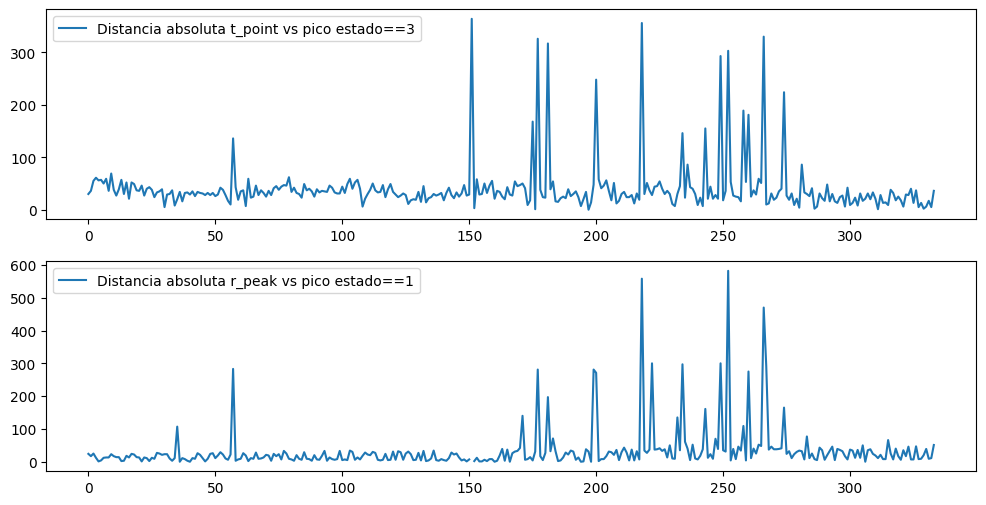

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t_dist_abs_arr, label='Distancia absoluta t_point vs pico estado==3')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(r_dist_abs_arr, label='Distancia absoluta r_peak vs pico estado==1')
#plt.ylim(0, 100)
plt.legend()
plt.show()

In [296]:
n=0

261


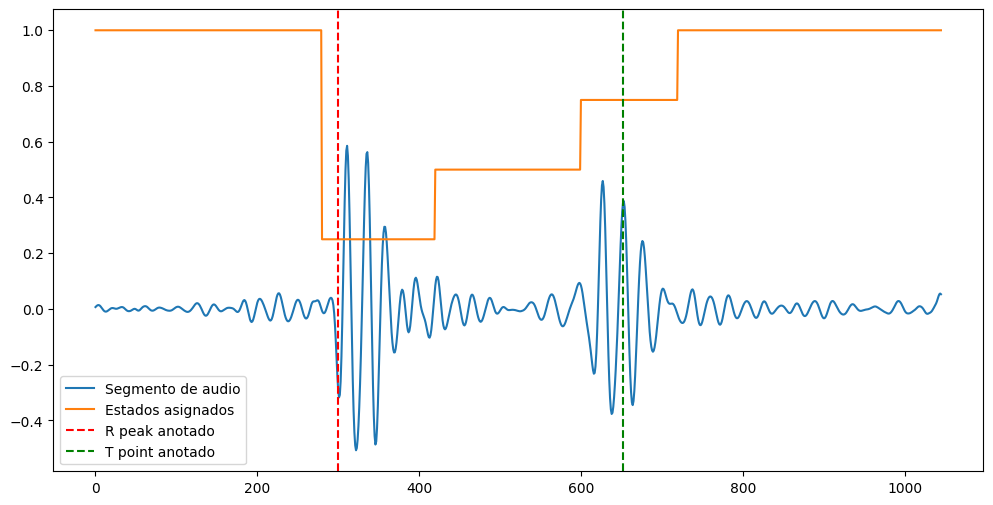

In [294]:

segment = audio_segments_test[n]
assigned_states = runSpringerSegmentationAlgorithm(
        segment,
        fs,
        logistic_regression_B_matrix,
        pi_vector,
        total_obs_distribution,
        figures=False
    )
#
# plot annotations
r_peak = audio_test_annotations[n][0]
t_point = audio_test_annotations[n][1]
print(n)
plt.figure(figsize=(12, 6))
plt.plot(segment, label='Segmento de audio')
plt.plot(assigned_states/np.abs(assigned_states).max(), label='Estados asignados')
plt.axvline(r_peak, color='r', linestyle='--', label='R peak anotado')
plt.axvline(t_point, color='g', linestyle='--', label='T point anotado')
plt.legend()
plt.show()
n=n+1

In [ ]:
n=0

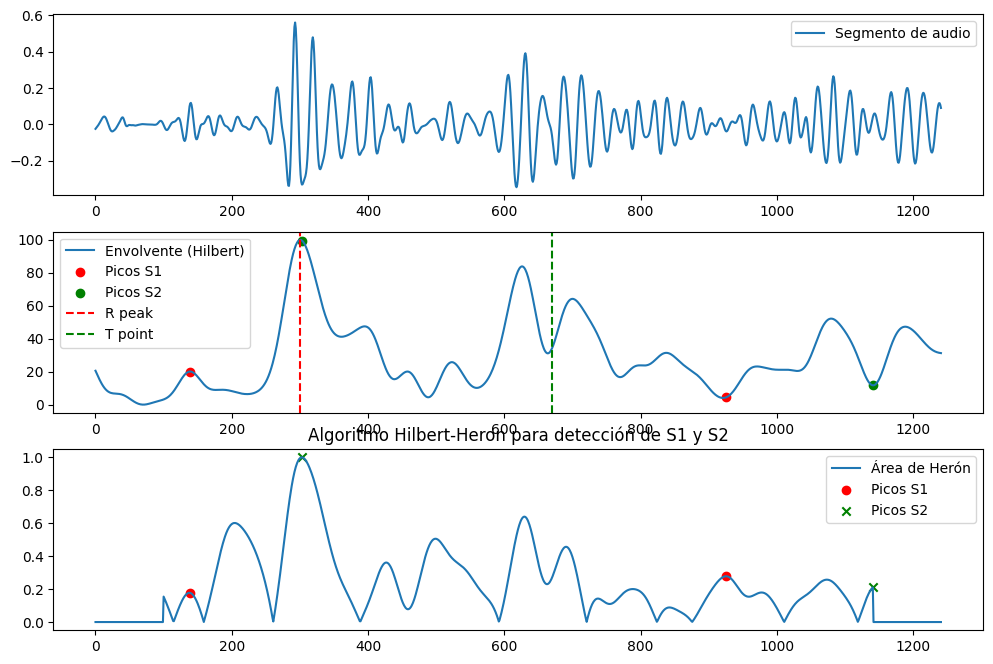

In [ ]:
def hilbert_heron_algorithm(signal, fs=1000, window_ms=50):
    """
    Implementación robusta del algoritmo Hilbert-Heron (Mondal et al., 2013).
    """
    # 1. Extracción de la envolvente usando la transformada de Hilbert
    analytic_signal = hilbert(signal)
    envelope = np.abs(analytic_signal)

    # 2. Filtro pasabajo (Ajustado a 25 Hz según la literatura para conservar la morfología)
    cutoff = 20.0  
    b, a = butter(5, cutoff, btype='lowpass', fs=fs)
    envelope = filtfilt(b, a, envelope)

    # Forzar el uso de float64 para evitar el colapso de precisión en Herón
    envelope = np.asarray(envelope, dtype=np.float64)

    # Normalizar la envolvente estrictamente entre 0 y 100
    env_min, env_max = np.min(envelope), np.max(envelope)
    if env_max > env_min:
        envelope = ((envelope - env_min) / (env_max - env_min)) * 100.0
    
    k = int((window_ms / 1000.0) * fs)
    n_samples = len(envelope)
    area_signal = np.zeros(n_samples, dtype=np.float64)
    
    # Parámetro geométrico clave: Forzamos una distancia horizontal fija (dx = 50.0) 
    # para emparejar la escala vertical (0-100) y hacer que los triángulos sean perfectos
    # matemáticamente hablando, evitando que (s-c) se vuelva 0.
    dx = 50.0 
    
    # 3. Fórmula de Herón
    for i in range(k, n_samples - k):
        y1 = envelope[i - k]
        y2 = envelope[i]
        y3 = envelope[i + k]
        
        # Lados usando Pitágoras con base dx fija
        a_side = np.sqrt(dx**2 + (y1 - y2)**2)
        b_side = np.sqrt(dx**2 + (y2 - y3)**2)
        c_side = np.sqrt((2 * dx)**2 + (y1 - y3)**2)
        
        s = (a_side + b_side + c_side) / 2.0
        
        val = s * (s - a_side) * (s - b_side) * (s - c_side)
        if val > 1e-9: # Tolerancia flotante
            area_signal[i] = np.sqrt(val)
            
    # 4. Normalizamos la señal resultante de las áreas a [0, 1]
    max_area = np.max(area_signal)
    if max_area > 0:
        area_signal = area_signal / max_area
    
    # 5. Detección de picos en la curva de las áreas
    # Si la señal tiene ruido residual, usar la media suele ser mejor que el 15% fijo,
    # pero mantendré tu umbral original para ser fiel a tu diseño.
    threshold = 0.15 * np.max(area_signal)
    min_dist = int(0.15 * fs) 
    
    peaks, _ = find_peaks(area_signal, height=threshold, distance=min_dist)
    
    # 6. Clasificación de S1 y S2 
    s1_peaks = []
    s2_peaks = []
    
    if len(peaks) > 1:
        intervals = np.diff(peaks)
        avg_interval = np.mean(intervals)
        
        for j in range(len(peaks)-1):
            # CAMBIO CLAVE: Usar <= en lugar de < previene que las listas queden vacías 
            # si los intervalos son idénticos o la señal es muy uniforme.
            if intervals[j] <= avg_interval: 
                if peaks[j] not in s1_peaks:
                    s1_peaks.append(peaks[j])
                if peaks[j+1] not in s2_peaks:
                    s2_peaks.append(peaks[j+1])
                    
    return envelope, area_signal, s1_peaks, s2_peaks

segment = audio_segments_test[n] 
hha_env, hha_area, hha_s1_peaks, hha_s2_peaks = hilbert_heron_algorithm(segment, fs=1000, window_ms=50)
r_peak = audio_test_annotations[n][0]
t_point = audio_test_annotations[n][1]

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(segment, label='Segmento de audio')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(hha_env, label='Envolvente (Hilbert)')
plt.scatter(hha_s1_peaks, hha_env[hha_s1_peaks], color='r', marker='o', label='Picos S1')
plt.scatter(hha_s2_peaks, hha_env[hha_s2_peaks], color='g', marker='o', label='Picos S2')
# plot the real positions of the R and T points for reference

plt.axvline(r_peak, color='r', linestyle='--', label='R peak')
plt.axvline(t_point, color='g', linestyle='--', label='T point')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(hha_area, label='Área de Herón')
plt.scatter(hha_s1_peaks, hha_area[hha_s1_peaks], color='r', marker='o', label='Picos S1')
plt.scatter(hha_s2_peaks, hha_area[hha_s2_peaks], color='g', marker='x', label='Picos S2')
plt.legend()
plt.title('Algoritmo Hilbert-Heron para detección de S1 y S2')
plt.show()
n = n + 1